In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [61]:
### THIS CELL MAKES YOU SIGN IN ON GOOGLE AND TRUST THIS JUPYTER FILE.

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/ECE 4715/ML_Project/data'

print(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECE 4715/ML_Project/data


In [62]:
# Set paths for train and test data
# data_dir = "./data"  # Using data dir from google drive, assuming the ML_Project
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
}


In [63]:
# Define the feature extraction function
def extract_features(data_dir, model, transform):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()  # Extract features
            features.append(outputs)
            labels.append(targets.numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels, dataset.classes

In [71]:
# Load a pre-trained ResNet model for feature extraction
feature_extractor = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
for param in feature_extractor.parameters():
    param.requires_grad = False

# Remove the final classification layer
feature_extractor.fc = torch.nn.Identity()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Extract features for train and test sets
train_features, train_labels, class_names = extract_features(train_dir, feature_extractor, data_transforms['train'])
test_features, test_labels, _ = extract_features(test_dir, feature_extractor, data_transforms['test'])

# Split train_features into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42
)

# Convert labels to integers
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# Check shapes of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Initialize and train the XGBoost model
print("Training XGBoost model...")
xgb_model = XGBClassifier(
    n_estimators=100,         # Number of trees
    learning_rate=0.1,        # Learning rate
    max_depth=6,              # Maximum depth of a tree
    random_state=42,          # Seed for reproducibility
    use_label_encoder=False,  # Suppress unnecessary warnings
    objective="multi:softprob",  # For multi-class classification
    eval_metric="mlogloss"       # Multi-class log loss
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

100%|██████████| 13/13 [00:01<00:00,  7.74it/s]
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


X_train shape: (640, 2048)
y_train shape: (640,)
X_val shape: (160, 2048)
y_val shape: (160,)
Training XGBoost model...
[0]	validation_0-mlogloss:2.17245
[1]	validation_0-mlogloss:2.07127
[2]	validation_0-mlogloss:1.99639
[3]	validation_0-mlogloss:1.92768
[4]	validation_0-mlogloss:1.87123
[5]	validation_0-mlogloss:1.81366
[6]	validation_0-mlogloss:1.76543
[7]	validation_0-mlogloss:1.72787
[8]	validation_0-mlogloss:1.68288
[9]	validation_0-mlogloss:1.64450
[10]	validation_0-mlogloss:1.61078
[11]	validation_0-mlogloss:1.58030
[12]	validation_0-mlogloss:1.55210
[13]	validation_0-mlogloss:1.52595
[14]	validation_0-mlogloss:1.50161
[15]	validation_0-mlogloss:1.47710
[16]	validation_0-mlogloss:1.45580
[17]	validation_0-mlogloss:1.44056
[18]	validation_0-mlogloss:1.42749
[19]	validation_0-mlogloss:1.41286
[20]	validation_0-mlogloss:1.40092
[21]	validation_0-mlogloss:1.38963
[22]	validation_0-mlogloss:1.37690
[23]	validation_0-mlogloss:1.36512
[24]	validation_0-mlogloss:1.35456
[25]	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [72]:
# Define the learning rate scheduler
##scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

In [73]:
# Evaluate the model
print("\nEvaluating the XGBoost model...")
train_preds = xgb_model.predict(train_features)
test_preds = xgb_model.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_preds) * 100
test_accuracy = accuracy_score(test_labels, test_preds) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")


Evaluating the XGBoost model...
Training Accuracy: 92.25%
Testing Accuracy: 57.29%


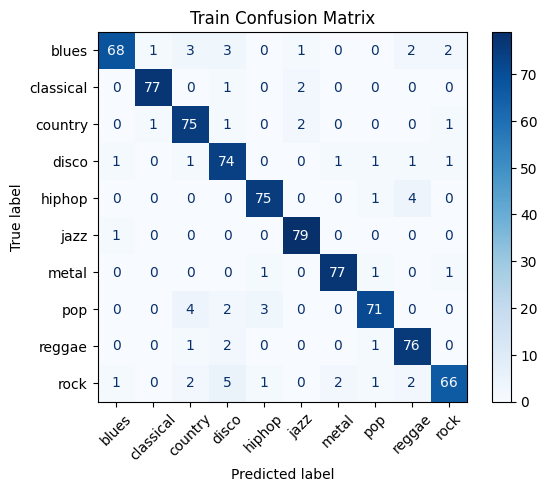

In [74]:
# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(train_labels, train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Train Confusion Matrix")
plt.show()

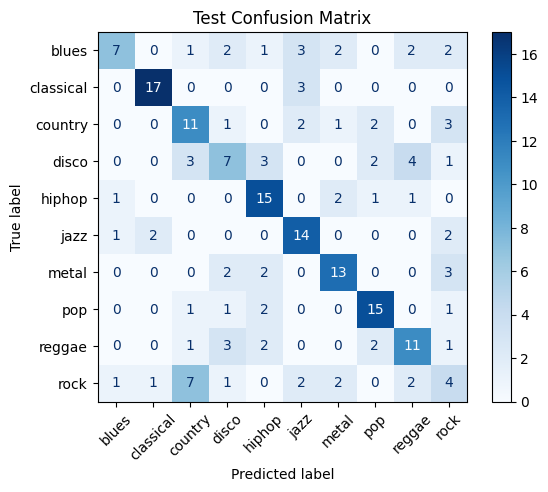

In [75]:
# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.show()

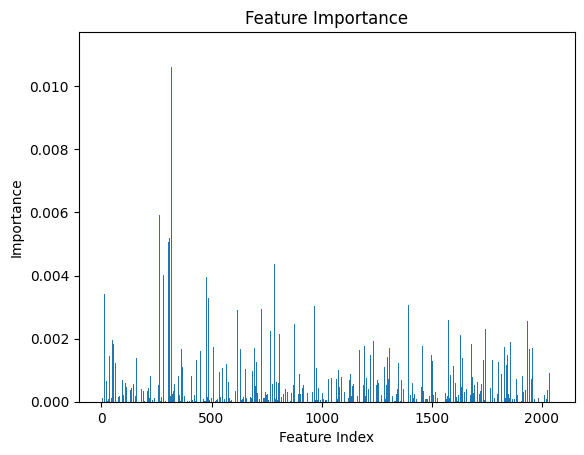

In [70]:
# Plot feature importance
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()